# Convolution Neural Network - Chess Prediction
- Seung Hyun Kim (skim449)
- Last run : 8/29 .18

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt

import loader

/Users/skim0119/github/chess_godeep/venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Load Data
- Any method for loading and parsing the data is included in loader.py
- First few moves in the chess game is not significant enough, so the first 4 moves are not included in the dataset.

In [2]:
# Pepare Dataset
x_dataset, t_dataset = loader.load()

388405 data loaded


### Data Split
- Test dataset is splited into two groups: one for the training and one for measuring accuracy.
- By spliting the training and testing group, we can reduce some amount of overfitting.

In [3]:
# Test Train Split
nData = len(x_dataset)
train_ratio = 0.8
indices = np.arange(nData)
np.random.shuffle(indices)
train_idx, test_idx = indices[:int(nData*train_ratio)], indices[int(nData*train_ratio):]
x_train, t_train, x_test, t_test = x_dataset[train_idx,:], t_dataset[train_idx,:], \
                                    x_dataset[test_idx,:], t_dataset[test_idx,:]

### Batch Training Data
- Since using the entire set of data is too large, we want to randomly select from the dataset and reduce the size.

In [4]:
def batch_data(size, x_train, t_train):
    """
    This method pulls mini-batch from x_train and t_train
    """
    sup_index = len(x_train)
    indices = np.random.randint(0,sup_index,size)
    return x_train[indices], t_train[indices]

## Graph
- 2 convolution layer, 1 fully-connected layer
    - First convolution layer includes relu activation function and max pooling layer.
    - Second convolution layer includes relu activation function.
    - Last fully connected layer includes flattening layer and sigmoid activation function.

In [6]:
#Graph
tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=(None, 8, 8, 6)) # input layer (one-hot board)
t = tf.placeholder(tf.float32, shape=(None, 2)) # return probability of winning (sigmoid)

global_step = tf.Variable(0, trainable=False, name='global_step')

with tf.name_scope('conv1'):
    # First convolution filter with kernel size 2x2, and pool by 2x2
    # input : [8, 8, 6]
    # output : [4,4,24]
    kernel_1 = tf.Variable(tf.random_uniform([2,2,6,24], -1.0, 1.0))
    conv1 = tf.nn.conv2d(x,
                         kernel_1,
                         strides=[1,1,1,1],
                         padding = 'SAME')
    conv1_act = tf.nn.relu(conv1)
    conv1_pool = tf.nn.max_pool(conv1_act,
                                ksize=[1,2,2,1],
                                strides=[1,2,2,1],
                                padding = 'SAME')
    #x = tf.nn.dropout(x, 0.5)

with tf.name_scope('conv2'):
    # Second convolution filter with kernel size 2x2
    # input : [4,4,24]
    # output : [4,4,48]
    kernel_2 = tf.Variable(tf.random_uniform([2,2,24,48], -1.0, 1.0))
    conv2 = tf.nn.conv2d(conv1_pool,
                         kernel_2,
                         strides=[1,1,1,1],
                         padding = 'SAME')
    conv2_act = tf.nn.relu(conv2)

with tf.name_scope('Dense1'):
    length = 4*4*48
    x_flat = tf.reshape(conv2_act, [-1,length]) # flatten
    weight_1 = tf.Variable(tf.truncated_normal(shape=[length, 2]))
    bias_1 = tf.Variable(tf.truncated_normal(shape=[2]))
    dense1 = tf.matmul(x_flat, weight_1) + bias_1
    output = tf.sigmoid(dense1)
"""
with tf.name_scope('Dense2'):
    # softmax
    weight_2 = tf.Variable(tf.truncated_normal(shape=[length, 2]))
    bias_2 = tf.Variable(tf.truncated_normal(shape=[2]))
    dense2 = tf.matmul(dense1, weight_2) + bias_2
    output = tf.sigmoid(dense2)
"""
with tf.name_scope('optimizer'):
    Loss = tf.reduce_mean(tf.square(output - t))
    Optimizer = tf.train.AdamOptimizer().minimize(Loss, global_step=global_step)
    tf.summary.scalar('loss', Loss)
    
# Save
merged = tf.summary.merge_all()

## Run Session

In [7]:
# Session
sess = tf.Session()
saver = tf.train.Saver(tf.global_variables())

writer = tf.summary.FileWriter('./logs', sess.graph)

ckpt = tf.train.get_checkpoint_state('./model')
if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
    saver.restore(sess, ckpt.model_checkpoint_path)
else:
    sess.run(tf.global_variables_initializer())

loss_table = []
pred_table = []

# Epoch
max_epoch = 100000
prediction_sample_size = 1000
batch_size = 50
progbar = tf.keras.utils.Progbar(max_epoch)
for epoch in range(max_epoch):
    progbar.update(epoch) # update progress bar
    
    x_train_batch, t_train_batch = batch_data(batch_size, x_train, t_train)

    feed_dict = {x:x_train_batch, t:t_train_batch}
    _, loss = sess.run([Optimizer, Loss], feed_dict=feed_dict)

    
    if epoch % 100 == 0:
        loss_table.append(loss)
       #print("\n", epoch, "epoch, Loss : ", loss)
        summary = sess.run(merged, feed_dict=feed_dict)
        writer.add_summary(summary, global_step=sess.run(global_step))
        
        # run prediction with test
        x_test_batch, t_test_batch = batch_data(prediction_sample_size, x_test, t_test)
        result = sess.run(output, feed_dict={x:x_test_batch})
        is_correct = np.equal(result.argmax(1), t_test_batch.argmax(1))
        pred_table.append(sum(is_correct)/prediction_sample_size)
        """
        correct_prediction = 0
        for i in range(prediction_sample_size):
            if (result[i][0] > result[i][1] and t_test_batch[i][0]) \
                or (result[i][0] < result[i][1] and t_test_batch[i][1]):
                correct_prediction += 1
        pred_table.append(correct_prediction / prediction_sample_size)
        """
    if epoch % 10000 == 0:
        saver.save(sess, './model/chess.ckpt', global_step=global_step)

saver.save(sess, './model/chess.ckpt', global_step=global_step)

 99992/100000 [============================>.] - ETA: 0s

'./model/chess.ckpt-100000'

## Graph the Result

Average of Last 10 Loss :  0.19849198311567307
Last Prediction :  68.40 %


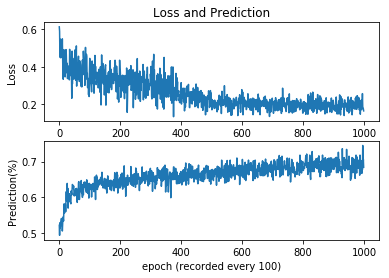

In [8]:
# Pred/Loss Graph
plt.subplot(2, 1, 1)
plt.plot(loss_table)
plt.title('Loss and Prediction')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(pred_table)
plt.xlabel('epoch (recorded every 100)')
plt.ylabel('Prediction(%)')

print('Average of Last 10 Loss : ', sum(loss_table[-10:])/10)
print('Last Prediction : ', "{0:0.2f}".format(pred_table[-1]*100),'%')